In [330]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
import numpy as np
import seaborn as sns
from matplotlib.animation import FuncAnimation

In [331]:
# Define shapefile object
SHAPEFILE = "tl_2021_us_state.shp"

# Read shapefile to new geopandas object
geo_df =  gpd.read_file(SHAPEFILE)
    
# Drop states that are not part of continental US
geo_df = geo_df.drop(geo_df.loc[geo_df['STUSPS'] == "AK"].index)
geo_df = geo_df.drop(geo_df.loc[geo_df['STUSPS'] == "HI"].index)
geo_df = geo_df.drop(geo_df.loc[geo_df['STUSPS'] == "PR"].index)

In [332]:
# Read claim volume file
states_df = pd.read_csv("states.csv") 
    
# Convert date to datetime
states_df.date = pd.to_datetime(states_df.date)

# Set a list for months in a np array
months = np.sort(np.unique(states_df.date.dt.month.values))

<IPython.core.display.Javascript object>


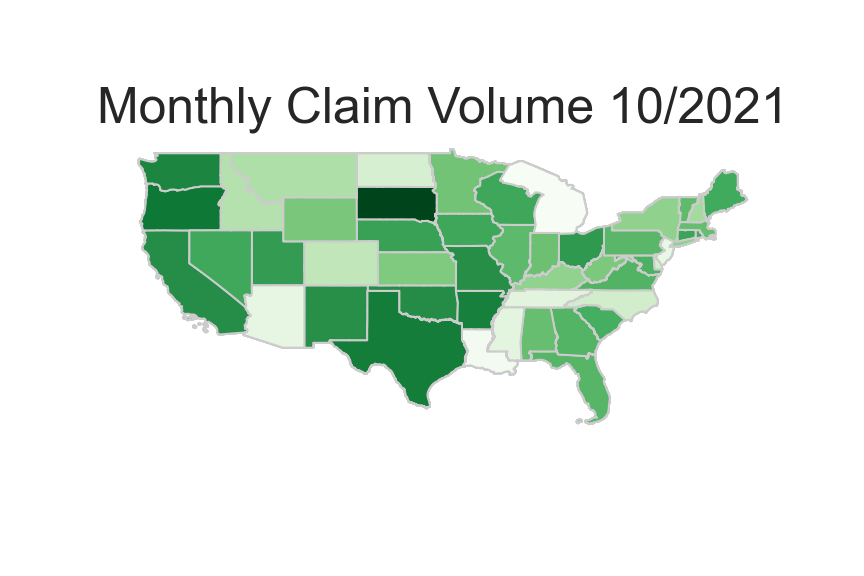

In [341]:
# Create figure and axes for Matplotlib
%matplotlib notebook
fig, ax = plt.subplots()

def animate(month):
    
    m_states_df = states_df[states_df.date.dt.month == month]
    m_states_df = m_states_df.groupby('state').sum()

    # Reshape Claim Volume to fit 2DArray reqs for normalize function
    d = m_states_df['claim_volume'].values.reshape(-1,1)

    # Normalize Claim Volume and append new column to DataFrame
    b = preprocessing.normalize(d, axis=0)
    scaled_df = m_states_df
    scaled_df['scaled'] = b

    # Merge Shapefile and Claim Volume Data Frames
    merged_df = pd.merge(left=geo_df, right=scaled_df, how='left', left_on='STUSPS', right_on='state')
    
    # Create Heatmap
    col = 'scaled'
    colors = 'Greens'
    sns.set_style(style = 'white')

    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    cmap=plt.get_cmap(colors)

    # Remove the axis and plot
    ax.axis('off')

    # Add a title
    ax.set_title('Monthly Claim Volume ' + str(month) + '/2021', fontdict={'fontsize': '25', 'fontweight': '3'})

    data = merged_df.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)
    return data


ani = FuncAnimation(fig, animate, frames=months, interval=50, repeat=False, blit=True)